# Stochastic Variational Inference (interpolation)

Implementation of Stochastic Variational Inference (SVI) using [PyTorch](https://pytorch.org/), for the purpose of uncertainty quantification.

We'll consider the "Gramacy & Lee 2012" function [[source](https://www.sfu.ca/~ssurjano/grlee12.html)]:

$f(x) = \frac{\sin(10 \pi x)}{2x} + (x-1)^4 \quad \forall x \in \mathbb{R}^+$

We'll also add a little bit of normally distributed noise around the output for good measure:

$y \sim \mathcal{N}(f(x), 0.1)$

The goal is to train a model capable of estimating its own uncertainty on unseen situations. To do so we'll split the dataset between a training / validation set on the one hand, and a test set defined on unseen input values on the other hand.

The function above is usually evaluated on the range $[0.5, 2.5]$. We'll train our model on the range $[0.5, 2.1]$ and then test it on the unseen set $[2.1, 2.5]$. 

The model is expected to perform less well on the unseen set, but hopefully the decrease in performance will be flagged by an increase in uncertainty. 

**UPDATE: inconclusive** - a single value isn't enough to predict the outcome.

## Setting up the environment

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')
    cwd = os.getcwd()

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

In [3]:
seed = 444
np.random.seed(seed);
torch.manual_seed(seed);
torch.set_default_dtype(torch.float64)

## Generating & visualising data

In [4]:
def generate_samples(σ, min_x=0.5, max_x=2.5, n_samples=1000):
    x = np.linspace(min_x, max_x, n_samples)[:, np.newaxis]
    y = (np.sin(10*np.pi*x) / (2 * x)) + (x - 1) ** 4 
    dist = torch.distributions.Normal(torch.from_numpy(y), σ)
    y_sample = dist.sample().detach().numpy()
    return x, y, y_sample

In [5]:
σ = 0.1
x, y, y_sample = generate_samples(σ)

In [6]:
def plot_data(x, y, y_sample, std_err=None):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    x_ = x.flatten()
    y_ = y.flatten()
    y_sample_ = y_sample.flatten()
    
    ax.plot(x_, y_, '-', color=palette[0], linewidth=3, label='Actual (no noise)')
    ax.scatter(x, y_sample_, color=palette[0], alpha=0.5, label='Actual (with noise)')
    
    if std_err is not None:
        ax.fill_between(x_, y_ - 2 * std_err, y_ + 2 * std_err, color=palette[0], alpha=0.2, label='2 standard error')
        
    ax.set_xlabel('input x')
    ax.set_ylabel('output y')
    ax.set_title(r'$f(x) \sim \frac{\sin(10 \pi x)}{2x} + (x-1)^4 + N(0, 0.1)$' + '\n')
    ax.legend()
    return ax

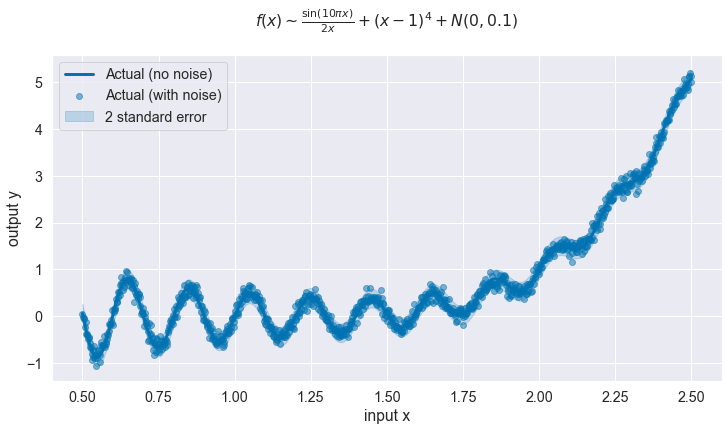

In [7]:
plot_data(x, y, y_sample, std_err=σ);

## Split between different sets

In [8]:
x, y, y_sample = generate_samples(σ, n_samples=10000)

In [9]:
def compute_train_test_split(x, y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    return (
        torch.from_numpy(x_train),
        torch.from_numpy(x_test),
        torch.from_numpy(y_train),
        torch.from_numpy(y_test),
    )

In [10]:
def find_cutoff_index(x, x_thres=2.1):
    for i in range(len(x)):
        if x[i,0] > 2.1:
            return i
    return i

cutoff_idx = find_cutoff_index(x)
x_train, x_val, y_train, y_val = compute_train_test_split(x[:cutoff_idx], y[:cutoff_idx], test_size=0.2)

x_test = torch.from_numpy(x[cutoff_idx:])
y_test = torch.from_numpy(y_sample[cutoff_idx:])

In [11]:
x_train.size(), x_val.size(), x_test.size()

(torch.Size([6400, 1]), torch.Size([1600, 1]), torch.Size([2000, 1]))

In [12]:
y_train.size(), y_val.size(), y_test.size()

(torch.Size([6400, 1]), torch.Size([1600, 1]), torch.Size([2000, 1]))

In [13]:
class StandardScaler():
    """
    Standardize data by removing the mean and scaling to unit variance.
    """
    def __init__(self):
        self.mean = None
        self.scale = None

    def fit(self, sample):
        self.mean = sample.mean(0, keepdim=True)
        self.scale = sample.std(0, unbiased=False, keepdim=True)
        return self

    def __call__(self, sample):
        return self.transform(sample)
    
    def transform(self, sample):
        return (sample - self.mean) / self.scale

    def inverse_transform(self, sample):
        return sample * self.scale + self.mean

In [14]:
x_scaler = StandardScaler().fit(torch.from_numpy(x))
y_scaler = StandardScaler().fit(torch.from_numpy(y_sample))

## Define model

In [15]:
class VariationalModel(torch.nn.Module):
    def __init__(self, n_hidden_encoder=100, n_hidden_decoder=300, n_encoding=50):
        super().__init__()
        
        self.encoder_shared1 = torch.nn.Linear(1, n_hidden_encoder)
        self.encoder_shared2 = torch.nn.Linear(n_hidden_encoder, n_hidden_encoder)
        self.encoder_mean = torch.nn.Linear(n_hidden_encoder, n_encoding)
        self.encoder_std = torch.nn.Linear(n_hidden_encoder, n_encoding)
        self.encoder_dropout = torch.nn.Dropout()
        
        self.decoder_inner_mean = torch.nn.Linear(n_encoding, n_hidden_decoder)
        self.decoder_mean = torch.nn.Linear(n_hidden_decoder, 1)
        self.decoder_dropout = torch.nn.Dropout()
        self.s = torch.nn.Parameter(torch.randn(()))

        self.prior = torch.distributions.MultivariateNormal(
            torch.zeros((n_encoding,)),
            torch.Tensor([1.0] * n_encoding) * torch.eye(n_encoding),
        )
        
    def encoder(self, x):
        shared = self.encoder_shared1(x)
        shared = F.relu(shared)
        shared = self.encoder_dropout(shared)
        shared = self.encoder_shared2(shared)
        shared = F.relu(shared)
        shared = self.encoder_dropout(shared)
        
        mean = self.encoder_mean(shared)
        std = F.softplus(self.encoder_std(shared))
        
        return torch.distributions.MultivariateNormal(
            mean,
            torch.diag_embed(std),
        )
    
    def decoder(self, x_enc):
        decoder_mean = self.decoder_inner_mean(x_enc)
        decoder_mean = F.relu(decoder_mean)
        decoder_mean = self.decoder_dropout(decoder_mean)
        
        decoder_mean = self.decoder_mean(decoder_mean)
        decoder_std = F.softplus(self.s)
        
        return torch.distributions.Normal(decoder_mean, decoder_std)
    
    def forward(self, x, sample_shape=torch.Size([])):
        encoder_dist = self.encoder(x)
        x_enc = encoder_dist.rsample(sample_shape)
        y_hat = self.decoder(x_enc)
        kl_divergence = torch.distributions.kl.kl_divergence(encoder_dist, self.prior)
        return y_hat, kl_divergence

In [16]:
def compute_loss(model, x, y):
    y_hat, kl_divergence = model(x)
    return torch.mean(-y_hat.log_prob(y) + kl_divergence)

In [17]:
def train_one_step(model, optimizer, x_batch, y_batch):
    model.train()
    optimizer.zero_grad()
    loss = compute_loss(model, x_batch, y_batch)
    loss.backward()
    optimizer.step()
    return loss

def compute_rmse(model, x_test, y_test, x_scaler=None, y_scaler=None):
    if x_scaler is None:
        x_test_ = x_test
    else:
        x_test_ = x_scaler(x_test)
    
    model.eval()
    y_hat, _ = model(x_test_)
    pred = y_hat.mean
    
    if y_scaler is None:
        return torch.sqrt(torch.mean((pred - y_test)**2))
    else:
        pred_ = y_scaler.inverse_transform(pred)
        return torch.sqrt(torch.mean((pred_ - y_test)**2))

In [18]:
def train(model, optimizer, scheduler, x_train_, x_val_, y_train_, y_val_, n_epochs, batch_size, print_every=10):
    x_train = x_scaler(x_train_)
    x_val = x_scaler(x_val_)
    y_train = y_scaler(y_train_)
    x_val = y_scaler(y_val_)
    
    train_losses, val_losses = [], []
    for epoch in range(n_epochs):
        batch_indices = sample_batch_indices(x_train, y_train, batch_size)
        
        batch_losses_t, batch_losses_v, batch_rmse_v = [], [], []
        for batch_ix in batch_indices:
            b_train_loss = train_one_step(model, optimizer, x_train[batch_ix], y_train[batch_ix])

            model.eval()
            b_val_loss = compute_loss(model, x_val, y_val)
            b_val_rmse = compute_rmse(model, x_val, y_val)

            batch_losses_t.append(b_train_loss.detach().numpy())
            batch_losses_v.append(b_val_loss.detach().numpy())
            batch_rmse_v.append(b_val_rmse.detach().numpy())
            
        scheduler.step()
            
        train_loss = np.mean(batch_losses_t)
        val_loss = np.mean(batch_losses_v)
        val_rmse = np.mean(batch_rmse_v)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if epoch == 0 or (epoch + 1) % print_every == 0:
            print(f'Epoch {epoch+1} | Validation loss = {val_loss:.4f} | Validation RMSE = {val_rmse:.4f}')
        
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(range(1, n_epochs + 1), train_losses, label='Train loss')
    ax.plot(range(1, n_epochs + 1), val_losses, label='Validation loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Overview')
    ax.legend()
    
    return train_losses, val_losses


def sample_batch_indices(x, y, batch_size, rs=None):
    if rs is None:
        rs = np.random.RandomState()
    
    train_ix = np.arange(len(x))
    rs.shuffle(train_ix)
    
    n_batches = int(np.ceil(len(x) / batch_size))
    
    batch_indices = []
    for i in range(n_batches):
        start = i + batch_size
        end = start + batch_size
        batch_indices.append(
            train_ix[start:end].tolist()
        )

    return batch_indices

## Training

In [19]:
learning_rate = 1e-4
momentum = 0.9
weight_decay = 5e-4
n_epochs = 60
batch_size = 128
print_every = 1

model = VariationalModel()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Halve learning rate every X steps.
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.5 ** (epoch // 20))

In [20]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{pytorch_total_params:,} trainable parameters')

36,002 trainable parameters


Epoch 1 | Validation loss = 2.6720 | Validation RMSE = 0.5597
Epoch 2 | Validation loss = 2.4929 | Validation RMSE = 0.6748
Epoch 3 | Validation loss = 2.4598 | Validation RMSE = 0.7345
Epoch 4 | Validation loss = 2.4480 | Validation RMSE = 0.7747
Epoch 5 | Validation loss = 2.4290 | Validation RMSE = 0.7971
Epoch 6 | Validation loss = 2.3848 | Validation RMSE = 0.7934
Epoch 7 | Validation loss = 2.3553 | Validation RMSE = 0.8061
Epoch 8 | Validation loss = 2.3165 | Validation RMSE = 0.8100
Epoch 9 | Validation loss = 2.2458 | Validation RMSE = 0.7893
Epoch 10 | Validation loss = 2.1759 | Validation RMSE = 0.7738
Epoch 11 | Validation loss = 2.1453 | Validation RMSE = 0.7907
Epoch 12 | Validation loss = 2.1036 | Validation RMSE = 0.8003
Epoch 13 | Validation loss = 2.0459 | Validation RMSE = 0.7979
Epoch 14 | Validation loss = 1.9917 | Validation RMSE = 0.7980
Epoch 15 | Validation loss = 1.9468 | Validation RMSE = 0.8017
Epoch 16 | Validation loss = 1.8918 | Validation RMSE = 0.7962
E

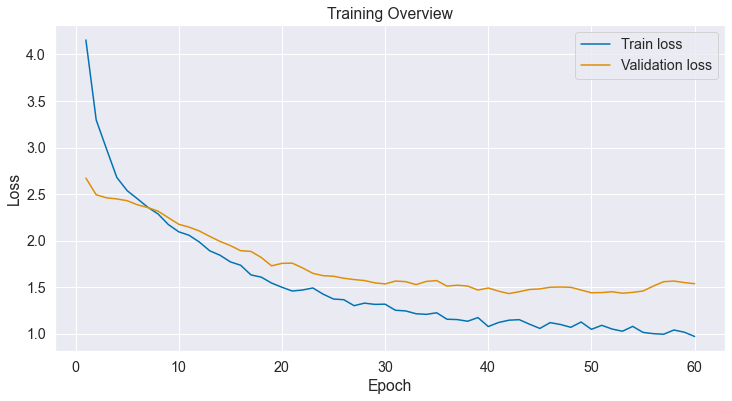

In [21]:
train(
    model, 
    optimizer, 
    scheduler, 
    x_train, 
    x_val, 
    y_train, 
    y_val, 
    n_epochs=n_epochs, 
    batch_size=batch_size, 
    print_every=print_every,
);

In [22]:
def plot_results(x, y_sample, y_pred_sample):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.scatter(x.flatten(), y_sample.flatten(), color=palette[0], label='Actual samples')
    ax.scatter(x.flatten(), y_pred_sample.flatten(), color=palette[1], label='Predicted samples')
    ax.set_xlabel('input x')
    ax.set_ylabel('output y')
    ax.legend()
    return ax

In [23]:
x_val_n = x_scaler(x_val)
y_dist, _ = model(x_val_n)
y_hat_s = y_dist.mean
y_hat = y_scaler.inverse_transform(y_hat_s)

In [24]:
val_rmse = float(compute_rmse(model, x_val, y_val, x_scaler, y_scaler).detach().numpy())
print(f'Validation RMSE = {val_rmse}')

Validation RMSE = 0.5091842581970948


In [33]:
val_r2 = r2_score(
    y_val.detach().numpy().flatten(),
    y_hat.detach().numpy().flatten(),
)
print(f'Validation $R^2$ = {val_r2}')

Validation $R^2$ = -0.026665375456965235


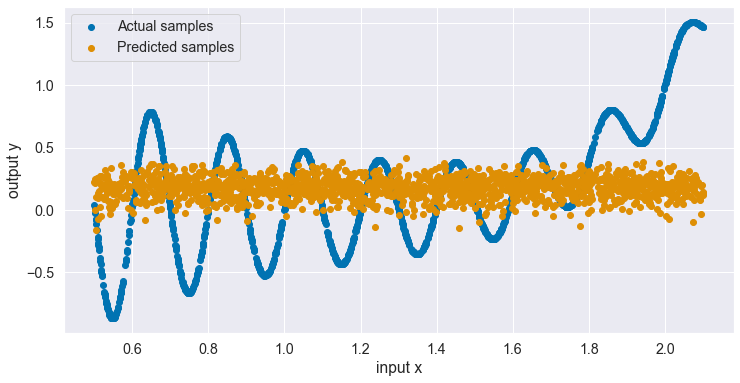

In [26]:
plot_results(
    x_val.detach().numpy(), 
    y_val.detach().numpy(), 
    y_hat.detach().numpy(),
);